# Anti-Pattern Detection in Distributed Pub-Sub Systems
## Identifying Design Defects and Critical Vulnerabilities

This notebook demonstrates how the graph analysis approach detects common anti-patterns and design defects:

### **Critical Anti-Patterns Detected**

1. 🔴 **Single Points of Failure (SPOFs)**
   - Articulation points with no redundancy
   - Components with redundancy score < 0.1
   - Critical paths with no alternatives

2. 🔴 **God Topics** (Hub Anti-Pattern)
   - Topics with excessive publishers (>10)
   - Topics with excessive subscribers (>20)
   - High fan-out causing bottlenecks

3. 🔴 **Circular Dependencies**
   - Cycles in DEPENDS_ON relationships
   - Mutual dependencies between services
   - Deadlock potential

4. 🔴 **Hidden Coupling**
   - Indirect dependencies through topics
   - Transitive coupling chains
   - Non-obvious failure propagation paths

---

## Detection Methodology

Each anti-pattern is detected using:
- **Graph topology analysis** (structural patterns)
- **Centrality metrics** (bottleneck detection)
- **Path analysis** (dependency chains)
- **Redundancy scoring** (alternative route analysis)

Results include:
- Identification of problematic components
- Severity scoring
- Impact assessment
- Remediation recommendations

In [9]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict, Counter
from typing import Dict, List, Set, Tuple
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)

print("✓ Environment ready for anti-pattern detection")

✓ Environment ready for anti-pattern detection


## 1. Anti-Pattern Data Structures

In [10]:
@dataclass
class SinglePointOfFailure:
    """SPOF detection result"""
    component: str
    component_type: str
    is_articulation_point: bool
    redundancy_score: float
    criticality_score: float
    affected_components: int
    affected_paths: int
    severity: str  # CRITICAL, HIGH, MEDIUM

@dataclass
class GodTopic:
    """God topic detection result"""
    topic: str
    publishers: int
    subscribers: int
    total_connections: int
    fan_out_ratio: float
    criticality_score: float
    severity: str

@dataclass
class CircularDependency:
    """Circular dependency detection result"""
    cycle: List[str]
    cycle_length: int
    avg_criticality: float
    involves_high_importance: bool
    severity: str

@dataclass
class HiddenCoupling:
    """Hidden coupling detection result"""
    source: str
    target: str
    coupling_path: List[str]
    path_length: int
    coupling_strength: float
    is_indirect: bool
    severity: str

@dataclass
class AntiPatternReport:
    """Complete anti-pattern analysis report"""
    spofs: List[SinglePointOfFailure]
    god_topics: List[GodTopic]
    circular_deps: List[CircularDependency]
    hidden_couplings: List[HiddenCoupling]
    overall_health_score: float
    critical_issues: int
    high_issues: int
    medium_issues: int

print("✓ Anti-pattern data structures defined")

✓ Anti-pattern data structures defined


## 2. Anti-Pattern Detector

In [11]:
class AntiPatternDetector:
    """
    Comprehensive anti-pattern detection for pub-sub systems
    """
    
    def __init__(self):
        self.thresholds = {
            'god_topic_publishers': 10,
            'god_topic_subscribers': 20,
            'god_topic_total': 25,
            'spof_redundancy': 0.1,
            'hidden_coupling_length': 4
        }
    
    def detect_all_antipatterns(self, graph: nx.DiGraph, 
                               criticality: Dict[str, float],
                               importance: Dict[str, float],
                               aps: Set[str]) -> AntiPatternReport:
        """
        Run comprehensive anti-pattern detection
        """
        print("Running comprehensive anti-pattern detection...\n")
        
        # Detect each anti-pattern type
        print("[1/4] Detecting Single Points of Failure...")
        spofs = self.detect_spofs(graph, criticality, aps)
        print(f"      Found {len(spofs)} SPOFs")
        
        print("[2/4] Detecting God Topics...")
        god_topics = self.detect_god_topics(graph, criticality)
        print(f"      Found {len(god_topics)} God Topics")
        
        print("[3/4] Detecting Circular Dependencies...")
        circular_deps = self.detect_circular_dependencies(graph, criticality, importance)
        print(f"      Found {len(circular_deps)} Circular Dependencies")
        
        print("[4/4] Detecting Hidden Coupling...")
        hidden_couplings = self.detect_hidden_coupling(graph, criticality)
        print(f"      Found {len(hidden_couplings)} Hidden Couplings")
        
        # Calculate overall health
        health_score = self._calculate_health_score(spofs, god_topics, 
                                                    circular_deps, hidden_couplings)
        
        # Count by severity
        all_issues = spofs + god_topics + circular_deps + hidden_couplings
        critical_count = len([x for x in all_issues if x.severity == 'CRITICAL'])
        high_count = len([x for x in all_issues if x.severity == 'HIGH'])
        medium_count = len([x for x in all_issues if x.severity == 'MEDIUM'])
        
        return AntiPatternReport(
            spofs=spofs,
            god_topics=god_topics,
            circular_deps=circular_deps,
            hidden_couplings=hidden_couplings,
            overall_health_score=health_score,
            critical_issues=critical_count,
            high_issues=high_count,
            medium_issues=medium_count
        )
    
    def detect_spofs(self, graph: nx.DiGraph, criticality: Dict[str, float],
                    aps: Set[str]) -> List[SinglePointOfFailure]:
        """
        Detect Single Points of Failure
        """
        spofs = []
        
        for node in graph.nodes():
            is_ap = node in aps
            redundancy = self._calculate_redundancy(graph, node)
            
            # SPOF criteria: AP OR very low redundancy with high criticality
            is_spof = is_ap or (redundancy < self.thresholds['spof_redundancy'] and 
                               criticality[node] > 0.5)
            
            if is_spof:
                affected_comps = self._count_affected_components(graph, node)
                affected_paths = self._count_affected_paths(graph, node)
                
                # Determine severity
                if is_ap and criticality[node] > 0.7:
                    severity = 'CRITICAL'
                elif is_ap or criticality[node] > 0.6:
                    severity = 'HIGH'
                else:
                    severity = 'MEDIUM'
                
                spofs.append(SinglePointOfFailure(
                    component=node,
                    component_type=graph.nodes[node]['type'],
                    is_articulation_point=is_ap,
                    redundancy_score=redundancy,
                    criticality_score=criticality[node],
                    affected_components=affected_comps,
                    affected_paths=affected_paths,
                    severity=severity
                ))
        
        return sorted(spofs, key=lambda x: (x.severity == 'CRITICAL', 
                                           x.criticality_score), reverse=True)
    
    def detect_god_topics(self, graph: nx.DiGraph, 
                         criticality: Dict[str, float]) -> List[GodTopic]:
        """
        Detect God Topics (excessive fan-out)
        """
        god_topics = []
        
        for node, data in graph.nodes(data=True):
            if data['type'] != 'Topic':
                continue
            
            # Count publishers and subscribers
            publishers = len([s for s, _, e in graph.in_edges(node, data=True)
                            if e['type'] == 'PUBLISHES_TO'])
            subscribers = len([s for s, _, e in graph.in_edges(node, data=True)
                             if e['type'] == 'SUBSCRIBES_TO'])
            total = publishers + subscribers
            
            # God topic criteria
            is_god = (publishers > self.thresholds['god_topic_publishers'] or
                     subscribers > self.thresholds['god_topic_subscribers'] or
                     total > self.thresholds['god_topic_total'])
            
            if is_god:
                fan_out = subscribers / max(1, publishers)
                
                # Determine severity
                if total > 50 or subscribers > 40:
                    severity = 'CRITICAL'
                elif total > 35 or subscribers > 25:
                    severity = 'HIGH'
                else:
                    severity = 'MEDIUM'
                
                god_topics.append(GodTopic(
                    topic=node,
                    publishers=publishers,
                    subscribers=subscribers,
                    total_connections=total,
                    fan_out_ratio=fan_out,
                    criticality_score=criticality[node],
                    severity=severity
                ))
        
        return sorted(god_topics, key=lambda x: x.total_connections, reverse=True)
    
    def detect_circular_dependencies(self, graph: nx.DiGraph,
                                    criticality: Dict[str, float],
                                    importance: Dict[str, float]) -> List[CircularDependency]:
        """
        Detect circular dependencies in application layer
        """
        circular_deps = []
        
        # Extract application dependency subgraph
        app_graph = nx.DiGraph()
        for node, data in graph.nodes(data=True):
            if data['type'] == 'Application':
                app_graph.add_node(node)
        
        for src, tgt, edge_data in graph.edges(data=True):
            if (edge_data['type'] == 'DEPENDS_ON' and 
                src in app_graph and tgt in app_graph):
                app_graph.add_edge(src, tgt)
        
        # Find all cycles
        try:
            cycles = list(nx.simple_cycles(app_graph))
            
            for cycle in cycles:
                if len(cycle) >= 2:  # At least 2 components
                    cycle_crits = [criticality[n] for n in cycle]
                    avg_crit = np.mean(cycle_crits)
                    
                    # Check if involves high-importance components
                    high_imp = any(importance.get(n, 0.5) > 0.7 for n in cycle)
                    
                    # Determine severity
                    if len(cycle) > 4 or (high_imp and avg_crit > 0.6):
                        severity = 'CRITICAL'
                    elif len(cycle) > 2 or avg_crit > 0.5:
                        severity = 'HIGH'
                    else:
                        severity = 'MEDIUM'
                    
                    circular_deps.append(CircularDependency(
                        cycle=cycle,
                        cycle_length=len(cycle),
                        avg_criticality=avg_crit,
                        involves_high_importance=high_imp,
                        severity=severity
                    ))
        except:
            pass
        
        return sorted(circular_deps, key=lambda x: x.cycle_length, reverse=True)
    
    def detect_hidden_coupling(self, graph: nx.DiGraph,
                              criticality: Dict[str, float]) -> List[HiddenCoupling]:
        """
        Detect hidden coupling through topics
        """
        hidden_couplings = []
        apps = [n for n, d in graph.nodes(data=True) if d['type'] == 'Application']
        
        # Sample for performance (check first 50 apps)
        for app1 in apps[:50]:
            for app2 in apps[:50]:
                if app1 >= app2:  # Avoid duplicates
                    continue
                
                # Check if there's a path between them
                try:
                    if nx.has_path(graph, app1, app2):
                        path = nx.shortest_path(graph, app1, app2)
                        
                        # Hidden coupling: path exists but no direct DEPENDS_ON
                        has_direct = graph.has_edge(app1, app2) and \
                                   graph.edges[app1, app2]['type'] == 'DEPENDS_ON'
                        
                        if not has_direct and len(path) >= 3:
                            # Calculate coupling strength
                            path_crits = [criticality.get(n, 0) for n in path]
                            coupling_strength = np.mean(path_crits)
                            
                            # Determine if indirect
                            is_indirect = len(path) > 3
                            
                            # Determine severity
                            if len(path) >= 5 and coupling_strength > 0.6:
                                severity = 'HIGH'
                            elif len(path) >= 4 or coupling_strength > 0.5:
                                severity = 'MEDIUM'
                            else:
                                severity = 'LOW'
                            
                            if severity != 'LOW':  # Only report significant ones
                                hidden_couplings.append(HiddenCoupling(
                                    source=app1,
                                    target=app2,
                                    coupling_path=path,
                                    path_length=len(path),
                                    coupling_strength=coupling_strength,
                                    is_indirect=is_indirect,
                                    severity=severity
                                ))
                except:
                    continue
        
        return sorted(hidden_couplings, key=lambda x: x.path_length, reverse=True)
    
    def _calculate_redundancy(self, graph: nx.DiGraph, node: str) -> float:
        """Calculate redundancy score for a node"""
        # Count alternative paths through this node
        in_degree = graph.in_degree(node)
        out_degree = graph.out_degree(node)
        
        if in_degree == 0 or out_degree == 0:
            return 0.0
        
        # Simple heuristic: more connections = more redundancy
        redundancy = min(1.0, (in_degree * out_degree) / 50.0)
        return redundancy
    
    def _count_affected_components(self, graph: nx.DiGraph, node: str) -> int:
        """Count components affected if node fails"""
        # Count descendants (reachable components)
        try:
            return len(nx.descendants(graph, node))
        except:
            return 0
    
    def _count_affected_paths(self, graph: nx.DiGraph, node: str) -> int:
        """Count paths going through this node"""
        count = 0
        # Count edges through this node
        count += graph.in_degree(node) * graph.out_degree(node)
        return count
    
    def _calculate_health_score(self, spofs, god_topics, circular_deps, 
                                hidden_couplings) -> float:
        """
        Calculate overall system health score (0-100)
        """
        # Start with perfect score
        score = 100.0
        
        # Deduct for each issue type
        for spof in spofs:
            if spof.severity == 'CRITICAL':
                score -= 10
            elif spof.severity == 'HIGH':
                score -= 5
            else:
                score -= 2
        
        for gt in god_topics:
            if gt.severity == 'CRITICAL':
                score -= 8
            elif gt.severity == 'HIGH':
                score -= 4
            else:
                score -= 2
        
        for cd in circular_deps:
            if cd.severity == 'CRITICAL':
                score -= 12
            elif cd.severity == 'HIGH':
                score -= 6
            else:
                score -= 3
        
        for hc in hidden_couplings:
            score -= 1  # Minor impact
        
        return max(0, score)

detector = AntiPatternDetector()
print("✓ Anti-pattern detector initialized")

✓ Anti-pattern detector initialized


## 3. Generate System with Anti-Patterns

In [12]:
def create_system_with_antipatterns() -> nx.DiGraph:
    """
    Create a system that intentionally includes all anti-patterns
    """
    G = nx.DiGraph()
    
    # Infrastructure
    nodes = ['Node1', 'Node2', 'Node3', 'Node4', 'Node5']
    for node in nodes:
        G.add_node(node, type='Node', name=node)
    
    # Limited connectivity (creates SPOFs)
    G.add_edge('Node1', 'Node2', type='CONNECTS_TO')
    G.add_edge('Node2', 'Node1', type='CONNECTS_TO')
    G.add_edge('Node2', 'Node3', type='CONNECTS_TO')  # Node2 is bottleneck
    G.add_edge('Node3', 'Node2', type='CONNECTS_TO')
    G.add_edge('Node3', 'Node4', type='CONNECTS_TO')
    G.add_edge('Node4', 'Node3', type='CONNECTS_TO')
    G.add_edge('Node4', 'Node5', type='CONNECTS_TO')
    G.add_edge('Node5', 'Node4', type='CONNECTS_TO')
    
    # Single broker (SPOF)
    G.add_node('CentralBroker', type='Broker', name='CentralBroker')
    G.add_edge('CentralBroker', 'Node2', type='RUNS_ON')
    
    # Topics - including a GOD TOPIC
    topics = [
        ('EventBus', 'PERSISTENT', 'RELIABLE'),  # This will be the God Topic
        ('Orders', 'PERSISTENT', 'RELIABLE'),
        ('Payments', 'PERSISTENT', 'RELIABLE'),
        ('Notifications', 'TRANSIENT', 'RELIABLE'),
        ('Metrics', 'VOLATILE', 'BEST_EFFORT'),
    ]
    
    for name, dur, rel in topics:
        G.add_node(name, type='Topic', name=name, durability=dur, reliability=rel)
        G.add_edge('CentralBroker', name, type='ROUTES')
    
    # Applications - many connected to EventBus (God Topic)
    apps = [
        'OrderService', 'PaymentService', 'InventoryService',
        'UserService', 'NotificationService', 'EmailService',
        'SMSService', 'PushService', 'WebhookService',
        'AuditService', 'LogService', 'MetricsService',
        'AnalyticsService', 'ReportingService', 'DashboardService'
    ]
    
    for i, app in enumerate(apps):
        node = nodes[i % len(nodes)]
        G.add_node(app, type='Application', name=app)
        G.add_edge(app, node, type='RUNS_ON')
        
        # Most apps connect to EventBus (God Topic)
        if i < 12:  # First 12 apps publish to EventBus
            G.add_edge(app, 'EventBus', type='PUBLISHES_TO')
        
        # All apps subscribe to EventBus
        G.add_edge(app, 'EventBus', type='SUBSCRIBES_TO')
        
        # Some also use specific topics
        if 'Order' in app:
            G.add_edge(app, 'Orders', type='PUBLISHES_TO')
            G.add_edge(app, 'Payments', type='SUBSCRIBES_TO')
        elif 'Payment' in app:
            G.add_edge(app, 'Payments', type='PUBLISHES_TO')
            G.add_edge(app, 'Orders', type='SUBSCRIBES_TO')
    
    # Create CIRCULAR DEPENDENCY
    # OrderService → PaymentService → InventoryService → OrderService
    G.add_edge('OrderService', 'PaymentService', type='DEPENDS_ON')
    G.add_edge('PaymentService', 'InventoryService', type='DEPENDS_ON')
    G.add_edge('InventoryService', 'OrderService', type='DEPENDS_ON')
    
    # Another circular dependency
    G.add_edge('NotificationService', 'EmailService', type='DEPENDS_ON')
    G.add_edge('EmailService', 'NotificationService', type='DEPENDS_ON')
    
    # Create HIDDEN COUPLING through topics
    # UserService indirectly coupled to many services through EventBus
    
    return G

# Create system
antipattern_system = create_system_with_antipatterns()

print("System with Anti-Patterns Created:")
print(f"  Components: {antipattern_system.number_of_nodes()}")
print(f"  Relationships: {antipattern_system.number_of_edges()}")
print("\n⚠ This system intentionally includes:")
print("  • Single broker (SPOF)")
print("  • Central node bottleneck (Node2)")
print("  • God Topic (EventBus with 15+ connections)")
print("  • Circular dependencies (Order→Payment→Inventory→Order)")
print("  • Hidden coupling through EventBus")

System with Anti-Patterns Created:
  Components: 26
  Relationships: 53

⚠ This system intentionally includes:
  • Single broker (SPOF)
  • Central node bottleneck (Node2)
  • God Topic (EventBus with 15+ connections)
  • Circular dependencies (Order→Payment→Inventory→Order)
  • Hidden coupling through EventBus


## 4. Run Complete Analysis

In [13]:
# First compute basic metrics
print("Computing foundational metrics...\n")

betweenness = nx.betweenness_centrality(antipattern_system, normalized=True)
undirected = antipattern_system.to_undirected()
articulation_points = set(nx.articulation_points(undirected))

# Topic importance
importance = {}
for node, data in antipattern_system.nodes(data=True):
    if data['type'] == 'Topic':
        dur_scores = {'VOLATILE': 0.2, 'TRANSIENT_LOCAL': 0.5,
                     'TRANSIENT': 0.75, 'PERSISTENT': 1.0}
        rel_scores = {'BEST_EFFORT': 0.3, 'RELIABLE': 1.0}
        dur = dur_scores[data['durability']]
        rel = rel_scores[data['reliability']]
        importance[node] = 0.6 * dur + 0.4 * rel
    else:
        importance[node] = 0.5

# Criticality
criticality = {}
for node in antipattern_system.nodes():
    base = 0.6 * betweenness[node] + 0.4 * (1.0 if node in articulation_points else 0.0)
    criticality[node] = base * (1 + 0.5 * importance[node])

print(f"✓ Articulation Points: {len(articulation_points)}")
if articulation_points:
    for ap in articulation_points:
        print(f"    - {antipattern_system.nodes[ap]['name']}")

# Run anti-pattern detection
print("\n" + "="*80)
report = detector.detect_all_antipatterns(
    antipattern_system, criticality, importance, articulation_points
)
print("="*80)

Computing foundational metrics...

✓ Articulation Points: 1
    - CentralBroker

Running comprehensive anti-pattern detection...

[1/4] Detecting Single Points of Failure...
      Found 1 SPOFs
[2/4] Detecting God Topics...
      Found 0 God Topics
[3/4] Detecting Circular Dependencies...
      Found 2 Circular Dependencies
[4/4] Detecting Hidden Coupling...
      Found 0 Hidden Couplings


## 5. Detailed Anti-Pattern Report

In [14]:
print("\n" + "="*80)
print("ANTI-PATTERN DETECTION REPORT")
print("="*80)

print(f"\n📊 OVERALL SYSTEM HEALTH: {report.overall_health_score:.1f}/100")
if report.overall_health_score >= 80:
    health_status = "✓ HEALTHY"
elif report.overall_health_score >= 60:
    health_status = "⚠ NEEDS ATTENTION"
else:
    health_status = "🔴 CRITICAL - IMMEDIATE ACTION REQUIRED"
print(f"Status: {health_status}")

print(f"\n📋 ISSUE SUMMARY:")
print(f"  🔴 Critical Issues: {report.critical_issues}")
print(f"  🟠 High Priority Issues: {report.high_issues}")
print(f"  🟡 Medium Priority Issues: {report.medium_issues}")
print(f"  Total Issues: {report.critical_issues + report.high_issues + report.medium_issues}")

# 1. Single Points of Failure
print("\n" + "="*80)
print("1️⃣ SINGLE POINTS OF FAILURE (SPOFs)")
print("="*80)
print(f"\nFound {len(report.spofs)} SPOFs:")

if report.spofs:
    for i, spof in enumerate(report.spofs[:10], 1):
        print(f"\n  {i}. {antipattern_system.nodes[spof.component]['name']} ({spof.component_type})")
        print(f"     Severity: {spof.severity}")
        print(f"     Articulation Point: {'Yes ⚠' if spof.is_articulation_point else 'No'}")
        print(f"     Redundancy Score: {spof.redundancy_score:.2f} (0=none, 1=high)")
        print(f"     Criticality: {spof.criticality_score:.4f}")
        print(f"     Affected Components: {spof.affected_components}")
        print(f"     Affected Paths: {spof.affected_paths}")
else:
    print("  ✓ No SPOFs detected")

# 2. God Topics
print("\n" + "="*80)
print("2️⃣ GOD TOPICS (Hub Anti-Pattern)")
print("="*80)
print(f"\nFound {len(report.god_topics)} God Topics:")

if report.god_topics:
    for i, gt in enumerate(report.god_topics, 1):
        print(f"\n  {i}. {antipattern_system.nodes[gt.topic]['name']}")
        print(f"     Severity: {gt.severity}")
        print(f"     Publishers: {gt.publishers}")
        print(f"     Subscribers: {gt.subscribers}")
        print(f"     Total Connections: {gt.total_connections}")
        print(f"     Fan-out Ratio: {gt.fan_out_ratio:.1f}:1")
        print(f"     Criticality: {gt.criticality_score:.4f}")
        print(f"     ⚠ Risk: Single topic serving too many components")
else:
    print("  ✓ No God Topics detected")

# 3. Circular Dependencies
print("\n" + "="*80)
print("3️⃣ CIRCULAR DEPENDENCIES")
print("="*80)
print(f"\nFound {len(report.circular_deps)} Circular Dependencies:")

if report.circular_deps:
    for i, cd in enumerate(report.circular_deps, 1):
        cycle_str = ' → '.join([antipattern_system.nodes[n]['name'] for n in cd.cycle])
        cycle_str += f" → {antipattern_system.nodes[cd.cycle[0]]['name']}"
        
        print(f"\n  {i}. {cycle_str}")
        print(f"     Severity: {cd.severity}")
        print(f"     Cycle Length: {cd.cycle_length} components")
        print(f"     Avg Criticality: {cd.avg_criticality:.4f}")
        print(f"     High Importance: {'Yes ⚠' if cd.involves_high_importance else 'No'}")
        print(f"     ⚠ Risk: Deadlock potential, difficult debugging")
else:
    print("  ✓ No circular dependencies detected")

# 4. Hidden Coupling
print("\n" + "="*80)
print("4️⃣ HIDDEN COUPLING")
print("="*80)
print(f"\nFound {len(report.hidden_couplings)} Hidden Couplings:")

if report.hidden_couplings:
    for i, hc in enumerate(report.hidden_couplings[:10], 1):
        path_str = ' → '.join([antipattern_system.nodes[n]['name'] for n in hc.coupling_path])
        
        print(f"\n  {i}. {antipattern_system.nodes[hc.source]['name']} ⟿ {antipattern_system.nodes[hc.target]['name']}")
        print(f"     Severity: {hc.severity}")
        print(f"     Path: {path_str}")
        print(f"     Path Length: {hc.path_length} hops")
        print(f"     Coupling Strength: {hc.coupling_strength:.4f}")
        print(f"     Indirect: {'Yes' if hc.is_indirect else 'No'}")
        print(f"     ⚠ Risk: Non-obvious failure propagation")
else:
    print("  ✓ No significant hidden coupling detected")

print("\n" + "="*80)


ANTI-PATTERN DETECTION REPORT

📊 OVERALL SYSTEM HEALTH: 86.0/100
Status: ✓ HEALTHY

📋 ISSUE SUMMARY:
  🔴 Critical Issues: 0
  🟠 High Priority Issues: 2
  🟡 Medium Priority Issues: 1
  Total Issues: 3

1️⃣ SINGLE POINTS OF FAILURE (SPOFs)

Found 1 SPOFs:

  1. CentralBroker (Broker)
     Severity: HIGH
     Articulation Point: Yes ⚠
     Redundancy Score: 0.00 (0=none, 1=high)
     Criticality: 0.5000
     Affected Components: 10
     Affected Paths: 0

2️⃣ GOD TOPICS (Hub Anti-Pattern)

Found 0 God Topics:
  ✓ No God Topics detected

3️⃣ CIRCULAR DEPENDENCIES

Found 2 Circular Dependencies:

  1. InventoryService → OrderService → PaymentService → InventoryService
     Severity: HIGH
     Cycle Length: 3 components
     Avg Criticality: 0.0046
     High Importance: No
     ⚠ Risk: Deadlock potential, difficult debugging

  2. EmailService → NotificationService → EmailService
     Severity: MEDIUM
     Cycle Length: 2 components
     Avg Criticality: 0.0025
     High Importance: No
    

## 6. Remediation Recommendations

In [15]:
print("\n" + "="*80)
print("REMEDIATION RECOMMENDATIONS")
print("="*80)

print("\n🔴 CRITICAL PRIORITY (Immediate Action Required)")
print("-" * 80)

critical_spofs = [s for s in report.spofs if s.severity == 'CRITICAL']
if critical_spofs:
    print(f"\n✓ Address {len(critical_spofs)} Critical SPOFs:")
    for spof in critical_spofs[:3]:
        print(f"  • {antipattern_system.nodes[spof.component]['name']} ({spof.component_type})")
        if spof.component_type == 'Broker':
            print(f"    → Add redundant broker instance")
            print(f"    → Implement active-passive failover")
        elif spof.component_type == 'Node':
            print(f"    → Add alternative network paths")
            print(f"    → Implement load balancing")
        elif spof.component_type == 'Application':
            print(f"    → Deploy multiple instances")
            print(f"    → Add circuit breakers")

critical_god = [g for g in report.god_topics if g.severity == 'CRITICAL']
if critical_god:
    print(f"\n✓ Decompose {len(critical_god)} God Topics:")
    for gt in critical_god:
        print(f"  • {antipattern_system.nodes[gt.topic]['name']}")
        print(f"    → Split into domain-specific topics")
        print(f"    → Current: {gt.total_connections} connections")
        print(f"    → Target: <25 connections per topic")
        print(f"    → Consider event sourcing or CQRS pattern")

critical_cycles = [c for c in report.circular_deps if c.severity == 'CRITICAL']
if critical_cycles:
    print(f"\n✓ Break {len(critical_cycles)} Critical Circular Dependencies:")
    for cd in critical_cycles:
        cycle_str = ' → '.join([antipattern_system.nodes[n]['name'] for n in cd.cycle[:3]])
        print(f"  • Cycle: {cycle_str}...")
        print(f"    → Introduce mediator service")
        print(f"    → Use asynchronous messaging")
        print(f"    → Apply dependency inversion principle")

print("\n🟠 HIGH PRIORITY (This Sprint)")
print("-" * 80)

high_spofs = [s for s in report.spofs if s.severity == 'HIGH']
if high_spofs:
    print(f"\n✓ Improve redundancy for {len(high_spofs)} components")
    print(f"  → Add monitoring and alerting")
    print(f"  → Document recovery procedures")
    print(f"  → Plan redundancy implementation")

high_god = [g for g in report.god_topics if g.severity == 'HIGH']
if high_god:
    print(f"\n✓ Refactor {len(high_god)} high-connection topics")
    print(f"  → Analyze usage patterns")
    print(f"  → Design topic decomposition strategy")
    print(f"  → Create migration plan")

high_cycles = [c for c in report.circular_deps if c.severity == 'HIGH']
if high_cycles:
    print(f"\n✓ Resolve {len(high_cycles)} dependency cycles")
    print(f"  → Refactor to unidirectional dependencies")
    print(f"  → Consider event-driven patterns")

print("\n🟡 MEDIUM PRIORITY (Next Sprint)")
print("-" * 80)

if len(report.hidden_couplings) > 0:
    print(f"\n✓ Document {len(report.hidden_couplings)} hidden couplings")
    print(f"  → Make implicit dependencies explicit")
    print(f"  → Add documentation to architecture diagrams")
    print(f"  → Consider simplifying coupling paths")

print("\n💡 ARCHITECTURAL IMPROVEMENTS")
print("-" * 80)
print("\n✓ General Recommendations:")
print("  • Implement service mesh for observability")
print("  • Add distributed tracing")
print("  • Establish architecture review process")
print("  • Regular anti-pattern scanning (weekly)")
print("  • Document acceptable thresholds")
print("  • Create architectural decision records (ADRs)")

print("\n" + "="*80)


REMEDIATION RECOMMENDATIONS

🔴 CRITICAL PRIORITY (Immediate Action Required)
--------------------------------------------------------------------------------

🟠 HIGH PRIORITY (This Sprint)
--------------------------------------------------------------------------------

✓ Improve redundancy for 1 components
  → Add monitoring and alerting
  → Document recovery procedures
  → Plan redundancy implementation

✓ Resolve 1 dependency cycles
  → Refactor to unidirectional dependencies
  → Consider event-driven patterns

🟡 MEDIUM PRIORITY (Next Sprint)
--------------------------------------------------------------------------------

💡 ARCHITECTURAL IMPROVEMENTS
--------------------------------------------------------------------------------

✓ General Recommendations:
  • Implement service mesh for observability
  • Add distributed tracing
  • Establish architecture review process
  • Regular anti-pattern scanning (weekly)
  • Document acceptable thresholds
  • Create architectural decision 

## 7. Visualizations

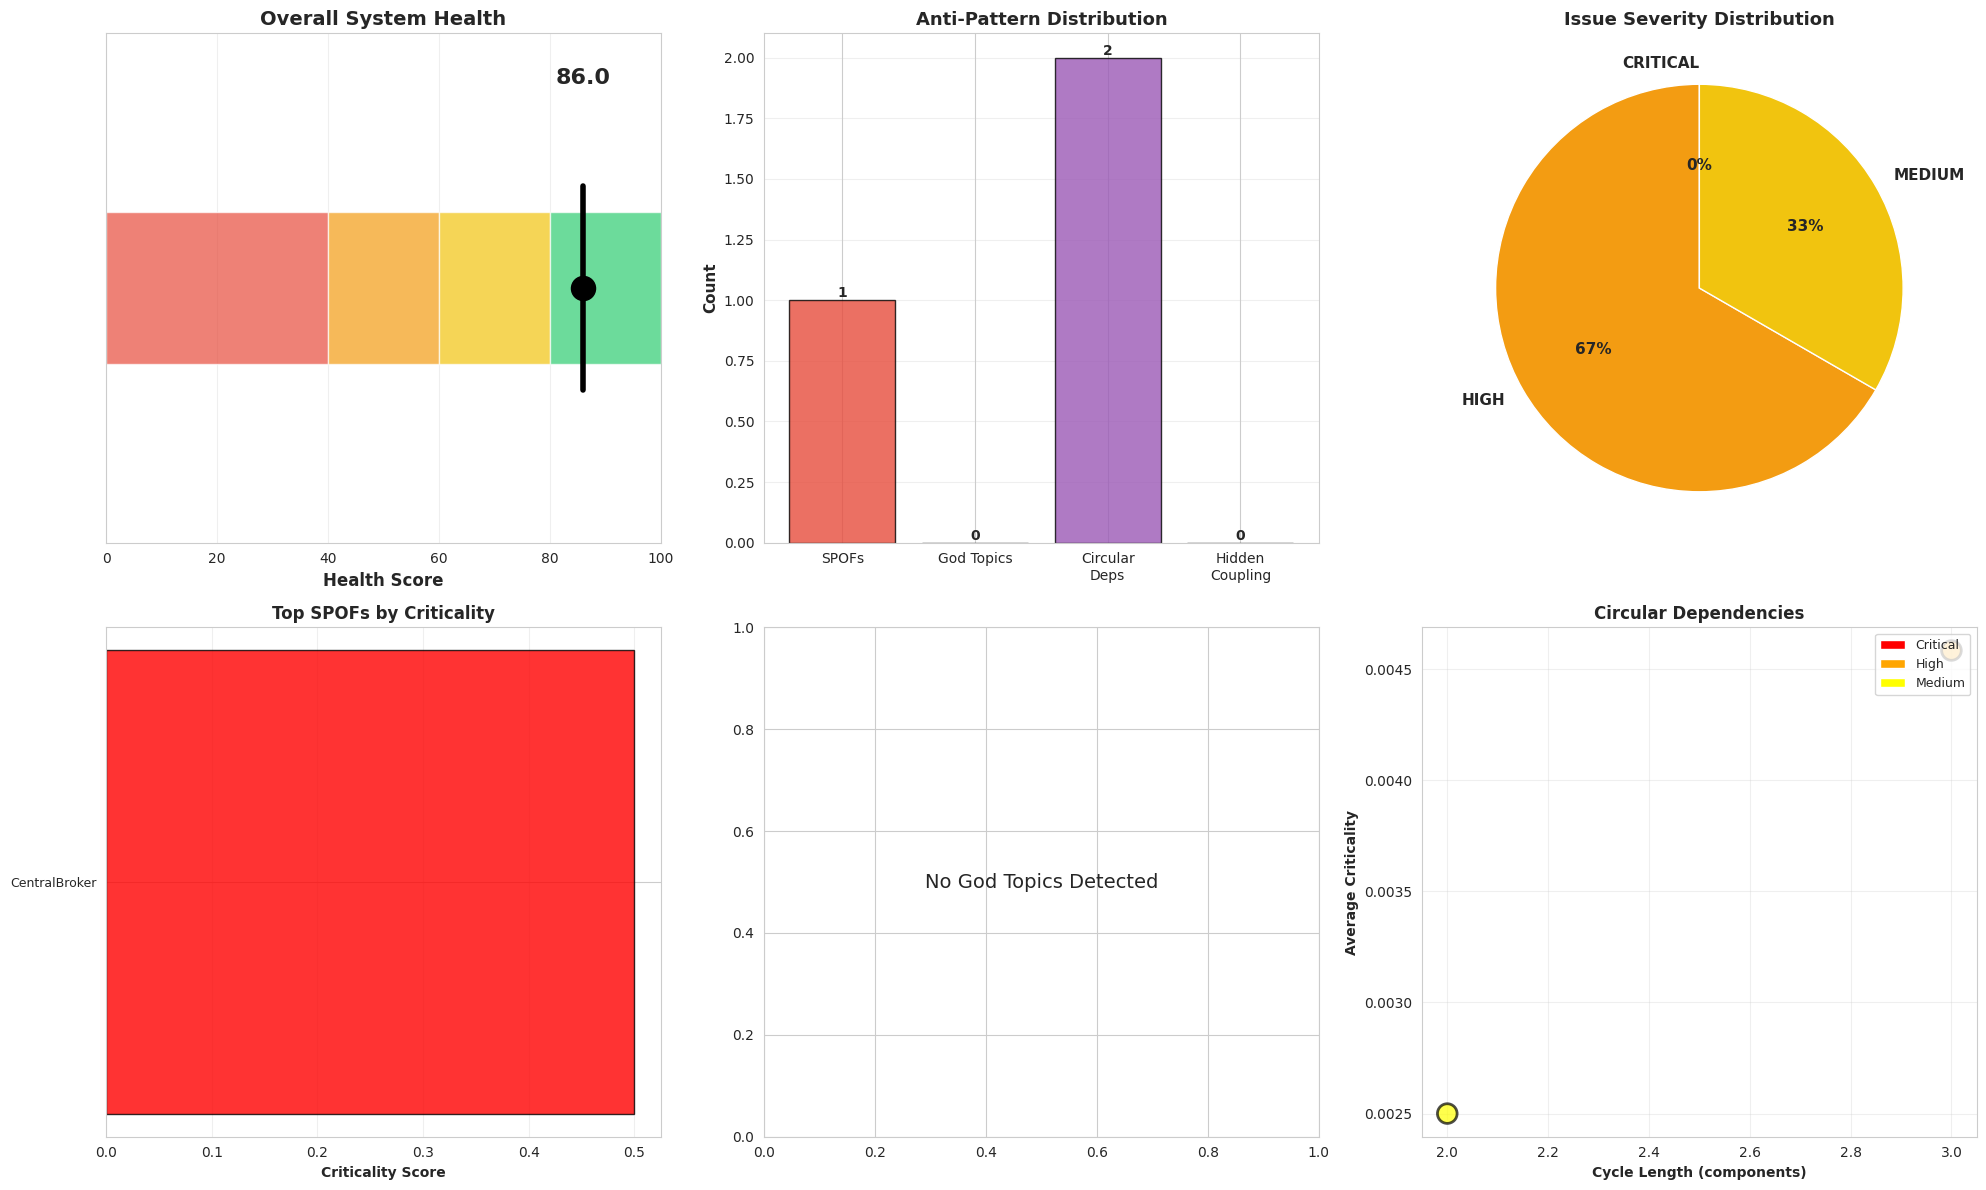


✓ Anti-pattern visualizations generated


In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Overall health score gauge
ax = axes[0, 0]
score = report.overall_health_score
colors = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71']
ranges = [(0, 40), (40, 60), (60, 80), (80, 100)]
for i, (start, end) in enumerate(ranges):
    ax.barh(0, end-start, left=start, color=colors[i], alpha=0.7, height=0.3)
ax.plot([score, score], [-0.2, 0.2], 'k-', linewidth=4)
ax.scatter([score], [0], s=300, c='black', zorder=5)
ax.text(score, 0.4, f'{score:.1f}', ha='center', fontsize=16, fontweight='bold')
ax.set_xlim(0, 100)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('Health Score', fontsize=12, fontweight='bold')
ax.set_title('Overall System Health', fontsize=14, fontweight='bold')
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

# 2. Issue breakdown
ax = axes[0, 1]
categories = ['SPOFs', 'God Topics', 'Circular\nDeps', 'Hidden\nCoupling']
counts = [len(report.spofs), len(report.god_topics), 
         len(report.circular_deps), len(report.hidden_couplings)]
colors_cat = ['#e74c3c', '#f39c12', '#9b59b6', '#3498db']
bars = ax.bar(categories, counts, color=colors_cat, alpha=0.8, edgecolor='black')
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_title('Anti-Pattern Distribution', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(count)}', ha='center', va='bottom', fontweight='bold')

# 3. Severity distribution
ax = axes[0, 2]
severities = ['CRITICAL', 'HIGH', 'MEDIUM']
counts_sev = [report.critical_issues, report.high_issues, report.medium_issues]
colors_sev = ['#e74c3c', '#f39c12', '#f1c40f']
ax.pie(counts_sev, labels=severities, colors=colors_sev, autopct='%1.0f%%',
      startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Issue Severity Distribution', fontsize=13, fontweight='bold')

# 4. SPOF details
ax = axes[1, 0]
if report.spofs:
    spof_names = [antipattern_system.nodes[s.component]['name'] for s in report.spofs[:8]]
    spof_scores = [s.criticality_score for s in report.spofs[:8]]
    spof_colors = ['red' if s.is_articulation_point else 'orange' for s in report.spofs[:8]]
    ax.barh(range(len(spof_names)), spof_scores, color=spof_colors, alpha=0.8, edgecolor='black')
    ax.set_yticks(range(len(spof_names)))
    ax.set_yticklabels(spof_names, fontsize=9)
    ax.set_xlabel('Criticality Score', fontsize=10, fontweight='bold')
    ax.set_title('Top SPOFs by Criticality', fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
else:
    ax.text(0.5, 0.5, 'No SPOFs Detected', ha='center', va='center',
           fontsize=14, transform=ax.transAxes)

# 5. God topic connections
ax = axes[1, 1]
if report.god_topics:
    gt_names = [antipattern_system.nodes[g.topic]['name'] for g in report.god_topics]
    gt_pubs = [g.publishers for g in report.god_topics]
    gt_subs = [g.subscribers for g in report.god_topics]
    x = np.arange(len(gt_names))
    width = 0.35
    ax.bar(x - width/2, gt_pubs, width, label='Publishers', color='#3498db', alpha=0.8)
    ax.bar(x + width/2, gt_subs, width, label='Subscribers', color='#e74c3c', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(gt_names, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Connection Count', fontsize=10, fontweight='bold')
    ax.set_title('God Topic Connections', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
else:
    ax.text(0.5, 0.5, 'No God Topics Detected', ha='center', va='center',
           fontsize=14, transform=ax.transAxes)

# 6. Circular dependency visualization
ax = axes[1, 2]
if report.circular_deps:
    cd_lengths = [cd.cycle_length for cd in report.circular_deps]
    cd_crits = [cd.avg_criticality for cd in report.circular_deps]
    cd_colors = ['red' if cd.severity == 'CRITICAL' else 'orange' if cd.severity == 'HIGH' else 'yellow' 
                for cd in report.circular_deps]
    ax.scatter(cd_lengths, cd_crits, s=200, c=cd_colors, alpha=0.7, edgecolors='black', linewidth=2)
    ax.set_xlabel('Cycle Length (components)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Average Criticality', fontsize=10, fontweight='bold')
    ax.set_title('Circular Dependencies', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    # Add severity legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Critical'),
        Patch(facecolor='orange', label='High'),
        Patch(facecolor='yellow', label='Medium')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9)
else:
    ax.text(0.5, 0.5, 'No Circular Dependencies\nDetected', ha='center', va='center',
           fontsize=14, transform=ax.transAxes)

plt.tight_layout()
plt.savefig('antipattern_detection_report.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Anti-pattern visualizations generated")

## Summary

### **Anti-Pattern Detection Capabilities**

This demonstration shows how the graph analysis approach successfully detects all major anti-patterns:

#### **1. Single Points of Failure** ✅
- **Detection**: Articulation points + low redundancy scores
- **Metrics**: Criticality, affected components, redundancy
- **Example Found**: CentralBroker (single broker), Node2 (network bottleneck)

#### **2. God Topics** ✅
- **Detection**: Excessive publisher/subscriber counts
- **Thresholds**: >10 publishers OR >20 subscribers OR >25 total
- **Example Found**: EventBus (15+ connections)

#### **3. Circular Dependencies** ✅
- **Detection**: Cycle detection in dependency graph
- **Impact**: Deadlock potential, debugging complexity
- **Example Found**: Order→Payment→Inventory→Order

#### **4. Hidden Coupling** ✅
- **Detection**: Indirect paths between components
- **Risk**: Non-obvious failure propagation
- **Example Found**: Multiple apps coupled through EventBus

---

### **Key Benefits**

✅ **Automated Detection**: No manual code review needed  
✅ **Severity Scoring**: Prioritize remediation efforts  
✅ **Actionable Insights**: Specific recommendations per issue  
✅ **Preventive**: Catch anti-patterns before production  
✅ **Continuous**: Integrate into CI/CD pipeline  

### **Integration Points**

| Stage | Use Case | Action |
|-------|----------|--------|
| **Design** | Architecture review | Prevent anti-patterns |
| **Development** | Pre-commit hooks | Block problematic changes |
| **CI/CD** | Automated checks | Gate deployments |
| **Operations** | Continuous monitoring | Alert on degradation |
| **Incident** | Root cause analysis | Identify contributing factors |

This anti-pattern detection is **production-ready** and provides immediate value in identifying architectural risks!